<a href="https://colab.research.google.com/github/etomoscow/DL-in-NLP/blob/master/hw2/task4_negative_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1.4: Negative sampling (15 points)

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling.

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [0]:
import random, torch, collections, time
import torch.nn as nn
from pprint import pprint
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np 

In [2]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip
with open('text8') as text_file:
    corpus = text_file.read().split()

--2020-02-24 15:17:25--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M   332KB/s    in 95s     

2020-02-24 15:19:01 (323 KB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


In [0]:
VOCABULARY_SIZE = 10000
UNK = '<UNK>'

def create_dataset(corpus, vocab_size=VOCABULARY_SIZE, unk_token=UNK):
    dataset = []
    counter_dict = collections.Counter(corpus)
    vocab = counter_dict.most_common(VOCABULARY_SIZE)
    words = [x[0] for x in vocab]
    words.append(unk_token)
    min_allowed_freq = vocab[-1][1]
    #use only high-frequency words
    #change all other words to UNK
    for _, word in enumerate(corpus):
        if counter_dict[word] > min_allowed_freq:
            dataset.append(word)
        else:
            dataset.append(unk_token)
        
    word2idx = {word: idx for (idx, word) in enumerate(words)}
    idx2word = {idx: word for (idx, word) in enumerate(words)}
    return dataset, word2idx, idx2word, len(words), counter_dict, words

In [0]:
data, word2idx, idx2word, vocab_size, counter_dict, vocab = create_dataset(corpus)

In [0]:
class Batcher(object):
    def __init__(self,dataset, window_size, batch_size, word2idx, idx2word):
        self.dataset = dataset
        self.window_size = window_size
        self.batch_size = batch_size
        self.word2idx = word2idx
        self.idx2word = idx2word

    def __iter__(self):
        return self
    
    def __next__(self):
        global index
        batch = []
        labels = []
        batch_central_context = []
        dataset = self.dataset 
        window_size = self.window_size
        batch_size = self.batch_size
        word2idx = self.word2idx
        idx2word = self.idx2word
        
        for _ in range(batch_size):
            # create a batch only if have at least
            #n words to the left and n words to the right
            #where n is window size
            if (index - window_size < 0) or (index + window_size > len(dataset)-1):
                #we need to increment index through epochs of learning
                index = (index + 1) % len(dataset)
            #now create context and batch
            else:
                #add word 
                batch.append(word2idx[dataset[index]])
                
                labels_batch = []
                sliding_window = dataset[index-window_size:index] + dataset[index+1: index+window_size+1]
                for word in sliding_window:
                    labels_batch.append(word2idx[word])
                labels.append(labels_batch)
                #again update index
                index = (index + 1) % len(dataset)
        
        return (labels, batch)

In [0]:
def onehot(batch, voc_size, window_size, batch_size):
    onehot_vector = torch.zeros([batch_size, voc_size])
    for index1,context in enumerate(batch):
        for index2 in context:
            onehot_vector[index1, index2] = onehot_vector[index1, index2] + 1
    return onehot_vector

In [0]:
class W2VNS(nn.Module):
  def __init__(self, vocab_size, output_size, window_size, k=20, weights=None):
    super(W2VNS, self).__init__()
    self.vocab_size = vocab_size
    self.weights = weights
    self.k = k
    self.out_size = output_size

    if self.weights is not None:
      assert min(self.weights) >= 0
      self.weights = torch.autograd.Variable(torch.from_numpy(weights)).float()
    
    self.in_emb = nn.Embedding(vocab_size, output_size)
    self.log_sigmoid = nn.LogSigmoid()
    
    initrange = (2.0 / (vocab_size + output_size)) ** 0.5  # Xavier init
    self.in_emb.weight.data.uniform_(-initrange, initrange)
  
  def forward(self, batch, labels):
    k = self.k
    batch_t = torch.LongTensor(batch).to(device=device)
    [batch_size, window_size] = batch_t.size()
    batch_t = batch_t.sum(1) / (2 * window_size)

    in_vec = self.in_emb(batch_t).to(device=device, dtype=dtype)
    out_vec = self.in_emb(torch.LongTensor(labels).to(device=device)).to(device=device, dtype=dtype)

    if self.weights is not None:
      nwords = torch.multinomial(self.weights, batch_size * self.k, replacement=True).view(batch_size, -1)
    else:
      nwords = torch.Tensor(batch_size, self.k).uniform_(0, self.vocab_size - 1).to(device=device, dtype=torch.long)
    noise = self.in_emb(nwords).to(device=device, dtype=dtype).neg()
    ploss = self.log_sigmoid(torch.bmm(out_vec.unsqueeze(1), in_vec.unsqueeze(2)).squeeze())
    nloss = self.log_sigmoid(torch.bmm(noise.view(batch_size, self.k, self.out_size), in_vec.unsqueeze(2)).squeeze()).sum(1)
    return -(ploss + nloss).mean()
  
  def predict(self, inputs):
    return self.in_emb(torch.tensor(inputs).to(device=device, dtype=torch.long))

In [21]:
batch_size = 4000
output_size = 100
window_size = 3
print_every = 100

USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

weights = np.array([counter_dict[word] for word in vocab]) ** (3 / 4)
weights = weights / weights.sum()
model = W2VNS(vocab_size=vocab_size, output_size=output_size, window_size=window_size, k=20)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
index = 0
batcher = Batcher(data, window_size, batch_size, word2idx, idx2word)
build_batch = iter(batcher)

losses = []
train_time = 0

using device: cuda


In [22]:
s = time.clock()
temp = []
for e in range(100000):
    batch, label = next(build_batch)
    model.train() 
    loss = model(batch, label).to(device=device, dtype=dtype)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    temp.append(loss.item())
    if e % 1000 == 0:
        losses.append(np.mean(temp))
        train_time = train_time + time.clock() - s
        s = time.clock()
        print('Iteration %d, loss = %lg' % (e, np.mean(temp)))
        temp = []
        print()

Iteration 0, loss = 14.5561

Iteration 1000, loss = 9.43191

Iteration 2000, loss = 8.30639

Iteration 3000, loss = 8.07993

Iteration 4000, loss = 7.77359

Iteration 5000, loss = 7.60152

Iteration 6000, loss = 7.64977

Iteration 7000, loss = 7.67321

Iteration 8000, loss = 7.4134

Iteration 9000, loss = 7.34647

Iteration 10000, loss = 7.36501

Iteration 11000, loss = 7.4694

Iteration 12000, loss = 7.19254

Iteration 13000, loss = 7.28033

Iteration 14000, loss = 7.17673

Iteration 15000, loss = 7.31007

Iteration 16000, loss = 7.18129

Iteration 17000, loss = 7.16488

Iteration 18000, loss = 7.05899

Iteration 19000, loss = 7.17595

Iteration 20000, loss = 7.20483

Iteration 21000, loss = 7.06218

Iteration 22000, loss = 7.00168

Iteration 23000, loss = 7.09031

Iteration 24000, loss = 7.17215

Iteration 25000, loss = 6.98339

Iteration 26000, loss = 6.96359

Iteration 27000, loss = 7.00619

Iteration 28000, loss = 7.11742

Iteration 29000, loss = 6.89515

Iteration 30000, loss = 6

Text(0, 0.5, 'loss value')

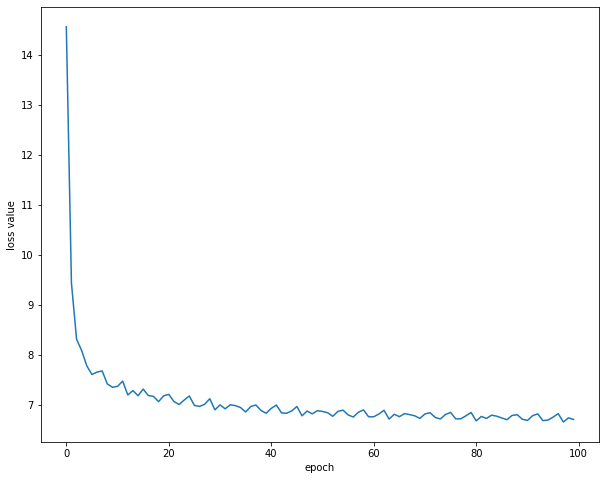

In [23]:
plt.figure(figsize=(10,8))
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss value')

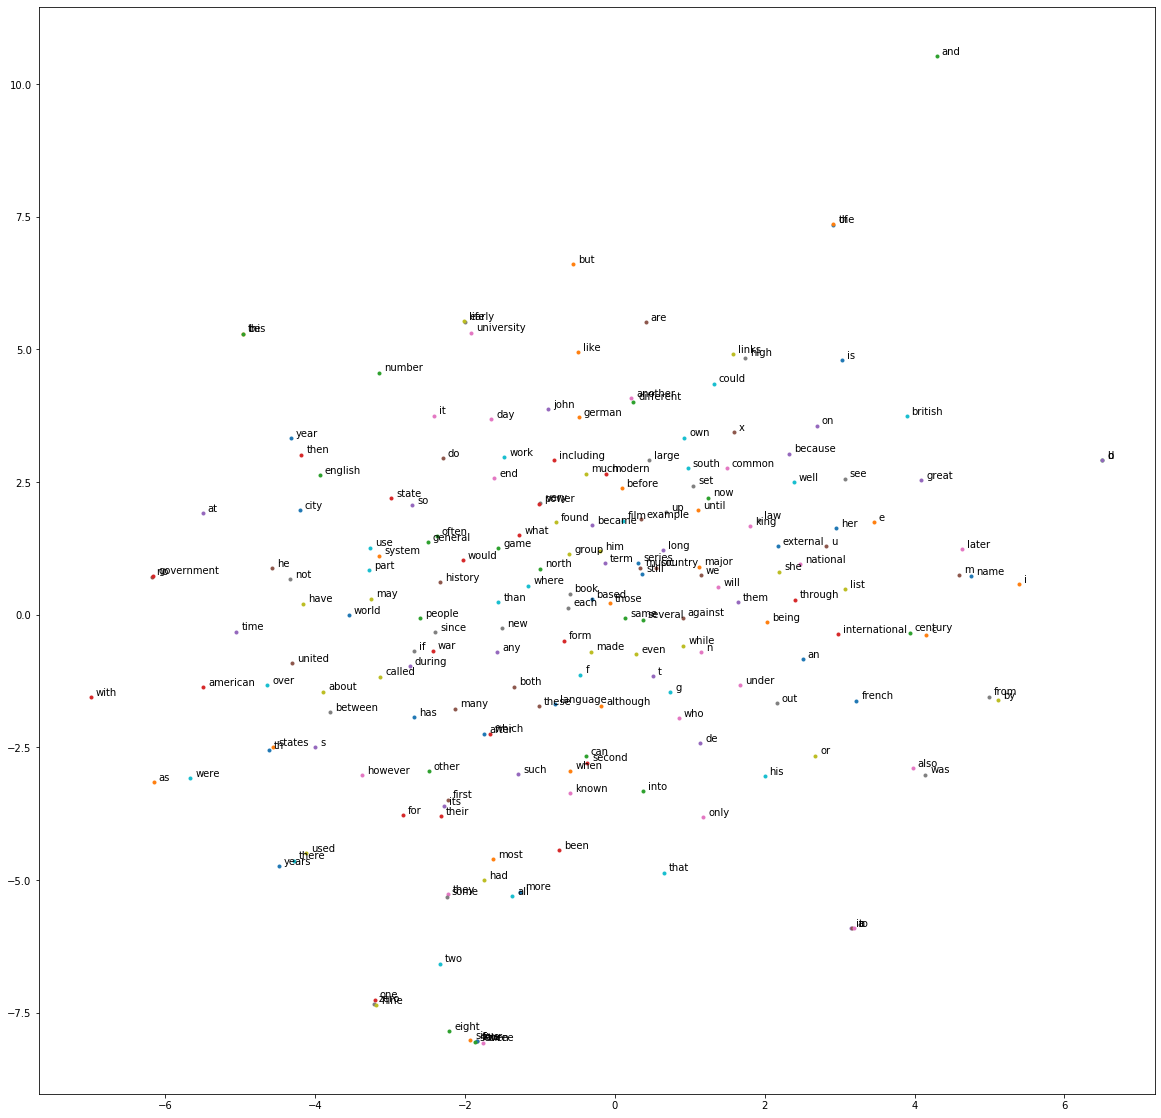

In [24]:
from sklearn.manifold import TSNE

idx2vec = lambda x: model.predict([x])[0].to(device=device, dtype=torch.float).detach().cpu().numpy()
word2vec = lambda x: model.predict([word2idx[x]])[0].to(device=device, dtype=torch.float).detach().cpu().numpy()

def plot_words(embs, labels):
    assert embs.shape[0] >= len(labels)
    plt.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embs[i,:]
        plt.scatter(x,y, marker='.')
        plt.annotate(label, (x,y), xytext=(5,2), textcoords='offset points')

tsne = TSNE(perplexity=30,n_components=2, init='pca', n_iter=10000)
num_words = 200
embs_to_plot = []
labels = []

for i in range(num_words):
    embs_to_plot.append(idx2vec(i))
    labels.append(idx2word[i])
embs_to_plot = tsne.fit_transform(np.array(embs_to_plot))

plot_words(embs_to_plot, labels)